In [98]:
import seaborn as sns
import pandas as pd
from sklearn.metrics import (accuracy_score, 
                            confusion_matrix, 
                            classification_report,
                            plot_confusion_matrix)
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV # resampling method
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
import matplotlib.pyplot as plt 

# importing scaler 
from sklearn.preprocessing import StandardScaler

# import vectorizers
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import time 

In [2]:
pwd

'/Users/emilynaftalin/Data_Science/General Assembly/dsi/projects/project_3/practice_code'

In [10]:
# read in cleaned stoicism & zen dataset 

stoic_zen = pd.read_csv('../datasets/clean_stoic_zen_tokenized.csv')

In [11]:
stoic_zen.head()

,label,merged,tokens
0,0,you need to fight your mind every time it trie...,"['you', 'need', 'to', 'fight', 'your', 'mind',..."
1,0,a phone call creates stronger bonds than text ...,"['a', 'phone', 'call', 'creates', 'stronger', ..."
2,0,"everything in your life every experience, ever...","['everything', 'in', 'your', 'life', 'every', ..."
3,0,the parable of the mexican fisherman got me re...,"['the', 'parable', 'of', 'the', 'mexican', 'fi..."
4,0,the key to success and productivity isn t to t...,"['the', 'key', 'to', 'success', 'and', 'produc..."


In [12]:
stoic_zen.tail()

,label,merged,tokens
5982,1,stoicism and self improvement i have just rece...,"['stoicism', 'and', 'self', 'improvement', 'i'..."
5983,1,should i go cold turkey on entertainment to pr...,"['should', 'i', 'go', 'cold', 'turkey', 'on', ..."
5984,1,"free law of attraction, the secret pdf and boo...","['free', 'law', 'of', 'attraction', 'the', 'se..."
5985,1,anxiety i have trouble rationalising with my a...,"['anxiety', 'i', 'have', 'trouble', 'rationali..."
5986,1,"""some poor, phoneless fool is probably sitting...","['some', 'poor', 'phoneless', 'fool', 'is', 'p..."


In [13]:
stoic_zen.shape

(5987, 3)

## Data Inspection and Pre-Processing 

_This time I will try a KNN model and then lemmatize and stem the words and see if this helps._ 

In [14]:
X = stoic_zen['merged']
y = stoic_zen['label']

# splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                   y, 
                                                   test_size=0.33,
                                                   shuffle=True,
                                                   stratify=y,
                                                   random_state=42)

### Baseline Model

In [16]:
# always check value counts for a classification problem! 
y.value_counts(normalize=True)

0    0.500251
1    0.499749
Name: label, dtype: float64

_Baseline accuracy = 50.0%_

## Modeling

## **`KNearestNeighbors`**

### `KNN + CountVectorizer` 

#### Transforming and Vectorizing the data

In [20]:
cvec = CountVectorizer(stop_words='english')

cvec.fit(X_train)

X_train_cvec = cvec.transform(X_train)
X_test_cvec = cvec.transform(X_test)

In [25]:
# scaling data using Standard Scaler 

# ss = StandardScaler()

# X_train_cvec_ss = ss.fit_transform(X_train_cvec)
# X_test_cvec_ss = ss.transform(X_test_cvec)

# # this doesn't work
# can't scale data that is already transformed by cvec? or that is already vectorized? 

In [27]:
# instantiating default KNN model 

knn = KNeighborsClassifier()

%time
knn.fit(X_train_cvec, y_train)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs


KNeighborsClassifier()

In [29]:
# evaluating default KNN model 

scores = cross_val_score(knn, X_train_cvec, y_train, cv = 10)  # 10 folds
print('Accuracy: {:.2f} ± {:.2f}'.format(scores.mean(), scores.std() * 2))

Accuracy: 0.54 ± 0.05


In [40]:
knn.score(X_train_cvec, y_train)

0.6472201446023436

In [42]:
knn.score(X_test_cvec, y_test)

0.5576923076923077

_54% is a terrible cross-val accuracy score-- barely better than the baseline. And this model is extremly overfit._

In [30]:
# instantiating KNN model with different parameters 

knn_30 = KNeighborsClassifier(n_neighbors=30, weights='distance')

%time
knn_30.fit(X_train_cvec, y_train)

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 4.05 µs


KNeighborsClassifier(n_neighbors=30, weights='distance')

In [31]:
# evaluating model with 30 nearest neighbors 

scores = cross_val_score(knn_30, X_train_cvec, y_train, cv = 10)  # 10 folds
print('Accuracy: {:.2f} ± {:.2f}'.format(scores.mean(), scores.std() * 2))

Accuracy: 0.55 ± 0.05


In [43]:
knn_30.score(X_train_cvec, y_train)

0.99950137122912

In [44]:
knn_30.score(X_test_cvec, y_test)

0.5501012145748988

_Accuracy = 55% is barely any better, and it's still extremely overfit. Time for a gridsearch..._

### `KNN + CountVectorizor + GridSearch` 

I will start with a basic gridsearch and then build a pipeline after that. 

In [33]:
# building gridsearch parameters
knn_params = {
    'n_neighbors': range(1, 40, 2),
    'metric': ['euclidean', 'manhattan'],
    'weights': ['uniform', 'distance']
}

In [34]:
# Instantiating gridsearch object
knn_gs = GridSearchCV(estimator=KNeighborsClassifier(),
                     param_grid=knn_params,
                     cv=5,
                     verbose=1)

In [35]:
# Fitting knn gridsearch on cvec-transformed data
knn_gs.fit(X_train_cvec, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': range(1, 40, 2),
                         'weights': ['uniform', 'distance']},
             verbose=1)

In [36]:
knn_gs.best_params_

{'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}

In [37]:
knn_gs.best_score_

0.5831423930832942

In [38]:
knn_gs.score(X_train_cvec, y_train)

0.99950137122912

In [39]:
knn_gs.score(X_test_cvec, y_test)

0.5936234817813765

_This model has a slightly higher accuracy on the testing set than the earlier KNN models, but it is still very overit._

### `KNN + Tf-Idf + GridSearch + Pipeline` 

Going to build a pipeline so that I can tune more of the hyperparameters. I will use Tf-Idf instead of CountVectorizer this time because of how overfit the gridsearched cvec model was. 

Also going to use a smaller test size than I have for other models. 

In [62]:
# redefining X and y for clarity 
X = stoic_zen['merged']
y = stoic_zen['label']

# splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                   y, 
                                                   test_size=0.25,
                                                   shuffle=True,
                                                   stratify=y,
                                                   random_state=42)


In [69]:
# tf-idf pipeline in two stages 

tfidf_knn_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('knn', KNeighborsClassifier())
])

In [70]:
pipe_params_knn_tfidf = {
    'tfidf__max_features':[2000, 3000, 4000, 5000],
    'tfidf__ngram_range': [(1,1),(1,2),(1,3)],
    'tfidf__min_df': [0.5, 0.75, 1],
    'knn__n_neighbors': range(1, 50, 3),
    'knn__metric': ['euclidean', 'manhattan'],
    'knn__weights': ['uniform', 'distance']
}

In [71]:
# gridsearch instantiation 

gs_tfidf_knn = GridSearchCV(tfidf_knn_pipe,
                          pipe_params_knn_tfidf,
                          cv = 5, 
                          verbose = 1,
                          n_jobs = 8)

In [72]:
# fitting gridsearch on training data
# no need to transform training data because the pipeline does it for us in SKLearn 

gs_tfidf_knn.fit(X_train, y_train)
%time

Fitting 5 folds for each of 2448 candidates, totalling 12240 fits


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.55790646 0.60066815 0.60579065]
  warnings.warn(


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


In [73]:
gs_tfidf_knn.best_params_

{'knn__metric': 'euclidean',
 'knn__n_neighbors': 46,
 'knn__weights': 'uniform',
 'tfidf__max_features': 5000,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 2)}

In [74]:
gs_tfidf_knn.best_score_

0.8521158129175946

In [75]:
gs_tfidf_knn.score(X_train, y_train)

0.8741648106904232

In [76]:
gs_tfidf_knn.score(X_test, y_test)

0.832999331997328

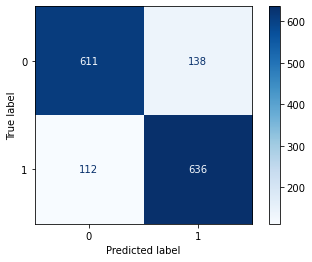

In [80]:
# predictions from KNN tf-idf gridsearch 
gs_tfidf_knn_preds = gs_tfidf_knn.predict(X_test)

#confusion matrix 
tn, fp, fn, tp = confusion_matrix(y_test, gs_tfidf_knn_preds).ravel()

plot_confusion_matrix(gs_tfidf_knn, X_test, y_test, cmap="Blues")

## **`Decision Trees`**

### `Decision Tree + CountVectorizer`

In [83]:
# redefining X and y just in case 

X = stoic_zen['merged']
y = stoic_zen['label']

# splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                   y, 
                                                   test_size=0.3,
                                                   shuffle=True,
                                                   stratify=y,
                                                   random_state=42)

In [84]:
cvec = CountVectorizer(stop_words='english')

cvec.fit(X_train)

X_train_cvec = cvec.transform(X_train)
X_test_cvec = cvec.transform(X_test)

In [85]:
# instantiating Decision Tree with default values for hyper parameters 

dt = DecisionTreeClassifier(random_state=42)

dt.fit(X_train_cvec, y_train)

DecisionTreeClassifier(random_state=42)

In [86]:
# Evaluating default DT model 

print(f'Training Score: {dt.score(X_train_cvec, y_train)}')
print(f'Testing Score: {dt.score(X_test_cvec, y_test)}')

Training Score: 0.9995226730310263
Testing Score: 0.8141346688925988


_First Decision Tree model is very overfit. Next I will go straight to a Tf-Idf Pipeline._

### `DecisionTree + Tf-Idf + GridSearch + Pipeline` 

In [90]:
# building tfidf pipeline in two stages 
tfidf_dt_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('dt', DecisionTreeClassifier())
])


# hyperparamters for transformer and estimator 
pipe_params_dt_tfidf = {
    'tfidf__max_features':[3000, 4500, 5000, 5500],
    'tfidf__ngram_range': [(1,1),(1,2),(1,3)],
    'tfidf__min_df': [0.75, 1],
    'dt__max_depth': [2,3,5,8],
    'dt__min_samples_split': [5, 10, 15],
    'dt__min_samples_leaf': [2, 4, 6],
    'dt__ccp_alpha': [0.001, 0.1, 10]
}
    
    
    
# gridsearch instantiation 
gs_tfidf_dt = GridSearchCV(tfidf_dt_pipe,
                          pipe_params_dt_tfidf,
                          cv = 5, 
                          verbose = 2,
                          n_jobs = 8)

In [92]:
# timer
t0 = time.time()

# gridsearching on our training data! 
gs_tfidf_dt.fit(X_train, y_train)

# How much time does each fit take? 
print(f'This cell took {time.time() - t0} seconds to run')

Fitting 5 folds for each of 2592 candidates, totalling 12960 fits


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.50023866 0.50023866 0.50023866]
  warnings.warn(


This cell took 3600.9114060401917 seconds to run


In [93]:
gs_tfidf_dt.best_params_

{'dt__ccp_alpha': 0.001,
 'dt__max_depth': 8,
 'dt__min_samples_leaf': 6,
 'dt__min_samples_split': 5,
 'tfidf__max_features': 3000,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 3)}

In [95]:
gs_tfidf_dt.best_score_

0.8338902147971361

In [96]:
# Evaluating gridsearched DT model 

print(f'Training Score: {gs_tfidf_dt.score(X_train, y_train)}')
print(f'Testing Score: {gs_tfidf_dt.score(X_test, y_test)}')

Training Score: 0.8436754176610979
Testing Score: 0.8274902615470228


_The gridsearched `DecisionTree` model with `Tf-Idf` transformer is not too overfit and has a fairly good accuracy score. Next I will look at the confusion matrix._

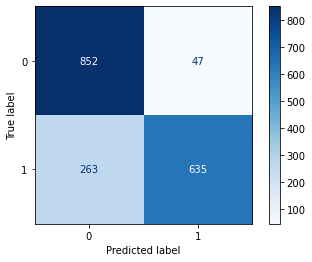

In [97]:
# predictions from KNN tf-idf gridsearch 
gs_tfidf_dt_preds = gs_tfidf_dt.predict(X_test)

#confusion matrix 
tn, fp, fn, tp = confusion_matrix(y_test, gs_tfidf_dt_preds).ravel()

plot_confusion_matrix(gs_tfidf_dt, X_test, y_test, cmap="Blues")

_Judging by the confusion matrix, posts are more often misidentified as being from the Zen subreddit than they are misidentified as being from the Stoicism subreddit._ 

### Bootstrapping/Bagging

In [102]:
# trying a basic 

cvec = CountVectorizer(stop_words='english')

cvec.fit(X_train)

X_train_cvec = cvec.transform(X_train)
X_test_cvec = cvec.transform(X_test)

In [103]:
bag = BaggingClassifier()

# Fit BaggingClassifier.
bag.fit(X_train_cvec, y_train)

BaggingClassifier()

In [108]:
bag.score(X_train_cvec, y_train)

0.9899761336515513

In [109]:
bag.score(X_test_cvec, y_test)

0.8414023372287145

### `Bagging/Decision Tree  + Tf-Idf + GridSearch + Pipeline` 

I will now build a gridsearched pipeline with Tfidf as my vectorizor and BaggingClassifier as my estimator. I will tune the hyper parameters grid search options slightly based on the best parameters from the Decision Tree classifier gridsearch above. 

In [115]:
# building tfidf pipeline in two stages 
tfidf_bag_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('bag', BaggingClassifier())
])

# hyperparamters for transformer and estimator 
pipe_params_bag_tfidf = {
    'tfidf__max_features':[2000, 3000, 4000, 5000],
    'tfidf__ngram_range': [(1,2),(1,3)],
    'tfidf__min_df': [0.75, 1],
    'bag__n_estimators': [5, 10, 15],
    'bag__max_samples': [0.65, 1.0],
    'bag__max_features':  [0.6, 0.8, 1.0],
    'bag__bootstrap': [True, False],
    'bag__warm_start': [True, False]
}
    
    
    
# gridsearch instantiation 
gs_tfidf_bag = GridSearchCV(tfidf_bag_pipe,
                          pipe_params_bag_tfidf,
                          cv = 5, 
                          verbose = 2,
                          n_jobs = 8)

In [116]:
# timer
t0 = time.time()

# gridsearching on our training data! 
gs_tfidf_bag.fit(X_train, y_train)

# How much time does each fit take? 
print(f'This cell took {time.time() - t0} seconds to run')

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.83747017 ...        nan 0.82434368 0.81718377]
  warnings.warn(


This cell took 11940.268226146698 seconds to run


In [118]:
# evaluating gridsearched bag model 

gs_tfidf_bag.score(X_train, y_train)

0.9823389021479714

In [120]:
gs_tfidf_bag.score(X_test, y_test)

0.8753478018920423

_Why is this bagged model so overfit?? :-(_

Will do another gridsearch to find out. 

Random Forest First... (next notebook)

In [121]:
gs_tfidf_bag.best_score_

0.871599045346062

In [122]:
gs_tfidf_bag.best_params_

{'bag__bootstrap': True,
 'bag__max_features': 0.6,
 'bag__max_samples': 0.65,
 'bag__n_estimators': 15,
 'bag__warm_start': True,
 'tfidf__max_features': 4000,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 3)}